# Predicting Stock Prices with Keras Neural-Nets
Jacob Ortiz,
Timothy Hanneman

CST 463 Dr. Bruns


In [ ]:
#Non-Standard Library imports, be sure to install
!pip install yfinance --upgrade --no-cache-dir
!pip install --user -U nltk
!pip install --user -U praw

     |████████████████████████████████| 5.5MB 18.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=16d0dbf2e18164eceff6c6b6710fff63fc49cecfc862b249ad726471f3c39dbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jas744im/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 1.4MB 13.5MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=0c974767bac158627eb98fc65a41be2420afc7427de73c3d17f50530493e9435
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 153kB 12.7MB/s 
     |██████

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential, Model
from keras import initializers
from keras import layers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras import Input

import timeit
import sklearn
from sklearn.preprocessing import MinMaxScaler
import sys
import os

from IPython import display
import math
from pprint import pprint
import random

import keras
import pydot
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot



In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import yfinance as yf

import keras
from keras import backend as K
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Using the yfinance API, we can get any historical market data from Yahoo! finance.

In [ ]:
# get the data
start_date = '2008-08-08'
end_date = '2016-07-01'
stock_data = yf.download('^GSPC', start_date, end_date)
stock_data = stock_data.drop('Adj Close', axis=1)

data = stock_data.values
print(stock_data)

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close      Volume
Date                                                                      
2008-08-08  1266.290039  1297.849976  1262.109985  1296.319946  4966810000
2008-08-11  1294.420044  1313.150024  1291.410034  1305.319946  5067310000
2008-08-12  1304.790039  1304.790039  1285.640015  1289.589966  4711290000
2008-08-13  1288.640015  1294.030029  1274.859985  1285.829956  4787600000
2008-08-14  1282.109985  1300.109985  1276.839966  1292.930054  4064000000
...                 ...          ...          ...          ...         ...
2016-06-24  2103.810059  2103.810059  2032.569946  2037.410034  7597450000
2016-06-27  2031.449951  2031.449951  1991.680054  2000.540039  5431220000
2016-06-28  2006.670044  2036.089966  2006.670044  2036.089966  4385810000
2016-06-29  2042.689941  2073.129883  2042.689941  2070.770020  4241740000
2016-06-30  2073.169922  2098.9

# Getting Data ready (Daily stock price data)

*ohlcv_histories* will be the x parameter. Each value in the list is an array containing whatever number history_points is of open, high, low, close, and volume values.
*technical_indicators* will be the other input to the LSTM model. It contains the simple moving average. To get this, we calculate the average of a selected range of prices, usually closing prices, by the number of periods in that range ([SMA](https://www.investopedia.com/terms/s/sma.asp)). We decided to add this indicator since just predicting prices based off of price data will not be accurate.

In [ ]:
def get_dataset(dataset, history_points):
    data = dataset

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    technical_indicators = []
    for history in ohlcv_histories_normalised:
        # We are using history[3] since we are taking the SMA of the closing price
        sma = np.mean(history[:, 3])
        technical_indicators.append(np.array([sma]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser, history_points


# The Model

## Baseline

### Simple Regression

Here we are getting the data ready for our simple regression model. This model will use 1788 days to train and the last 199 as test. It won't use techincal 

In [ ]:
np.random.seed(2)
tf.random.set_seed(2)

# X param                              y param
ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser, history_points = get_dataset(data, 1)

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)

(1788, 1, 5)
(199, 1, 5)


In our simple regression model, we are using the value of the last day to predict the next one. It seems really accurate, but realistically price change over a day is not that much, so given a price, the model will most likely spit out the same price.

[-0.0019964]


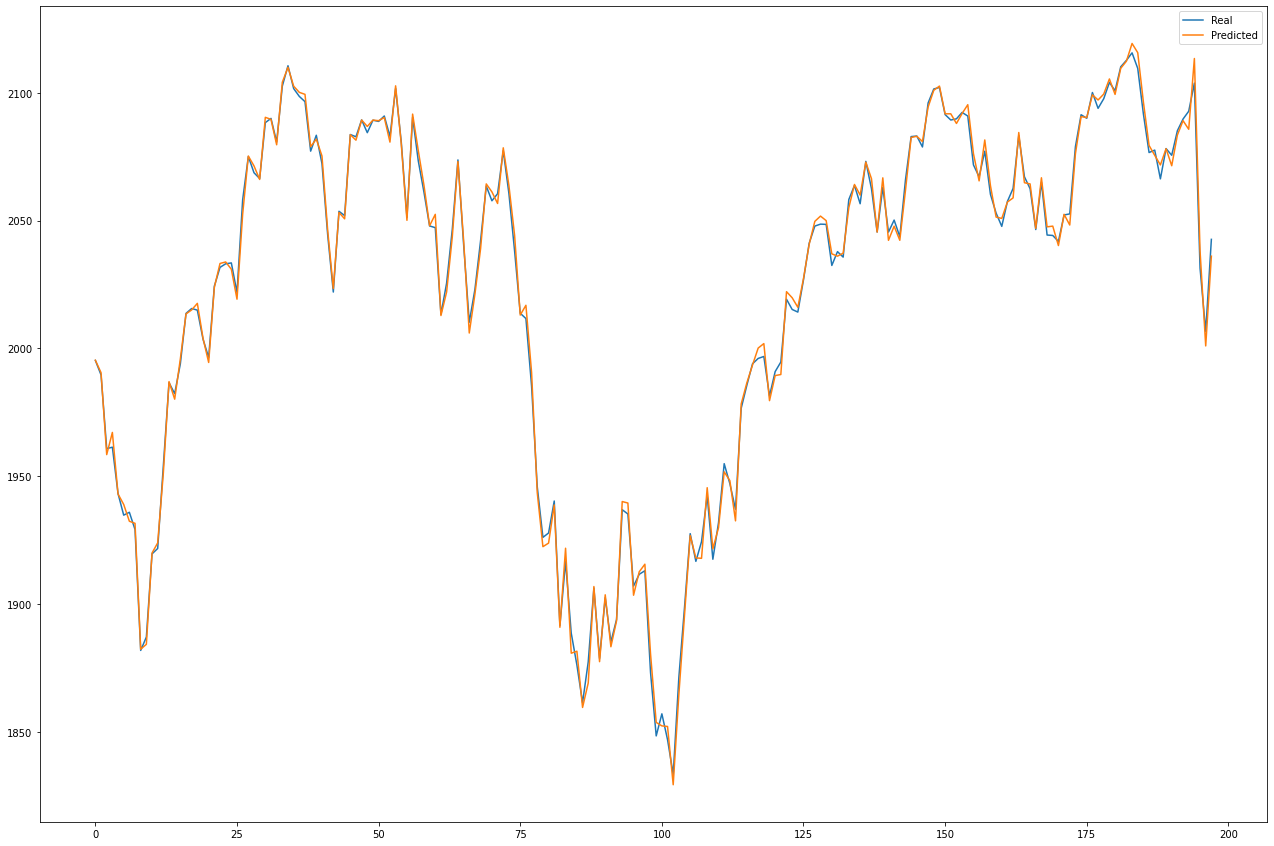

In [ ]:
nsamples, nx, ny = ohlcv_train.shape
ohlvc_train_2d = ohlcv_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = ohlcv_test.shape
ohlvc_test_2d = ohlcv_test.reshape((nsamples,nx*ny))

reg = LinearRegression()
reg.fit(ohlvc_train_2d, y_train)
print(reg.intercept_)

predicted = reg.predict(ohlvc_test_2d)
predicted = y_normaliser.inverse_transform(predicted)

plt.gcf().set_size_inches(22, 15, forward=True)

real = plt.plot(unscaled_y_test[0:-1], label='real')
pred = plt.plot(predicted[0:-1], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.show();


### Differences in RMSE over *n* period of days

Here we can see how using more than one day to predict the next becomes more unpredictable. The more prior days we use to predict next day value, the more error we see. The last value would be the number of days of the whole test set.

In [ ]:
number_days = [3, 10, 25, 50, 100, ohlcv_test.shape[0]]
temp_data = stock_data['Open'].values

RMSE using 3 days prior: 22.536250912928796


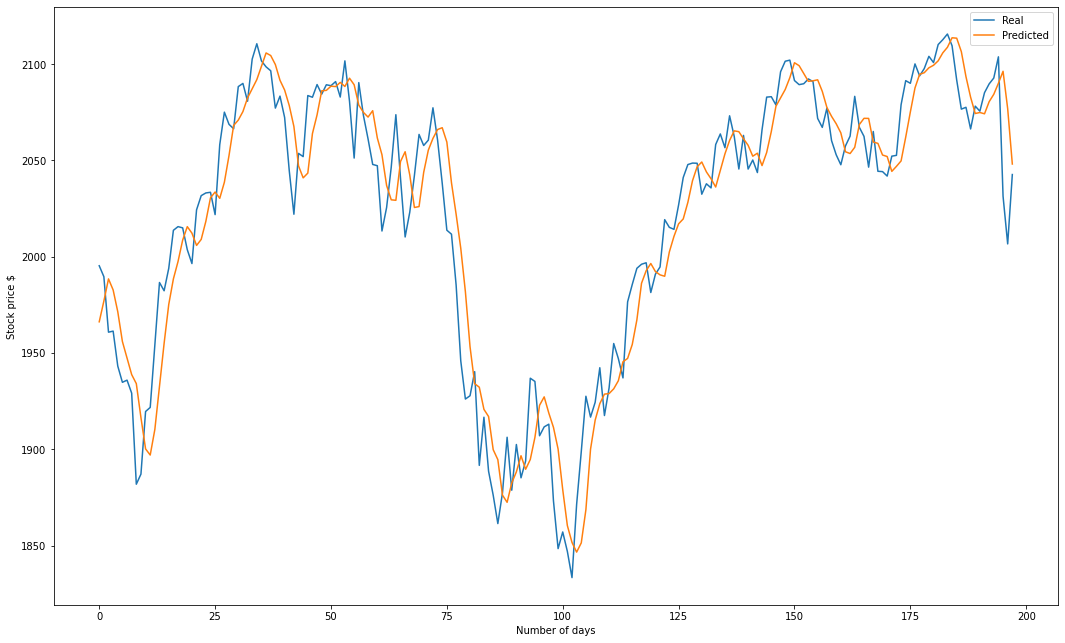

RMSE using 10 days prior: 35.00645916719754


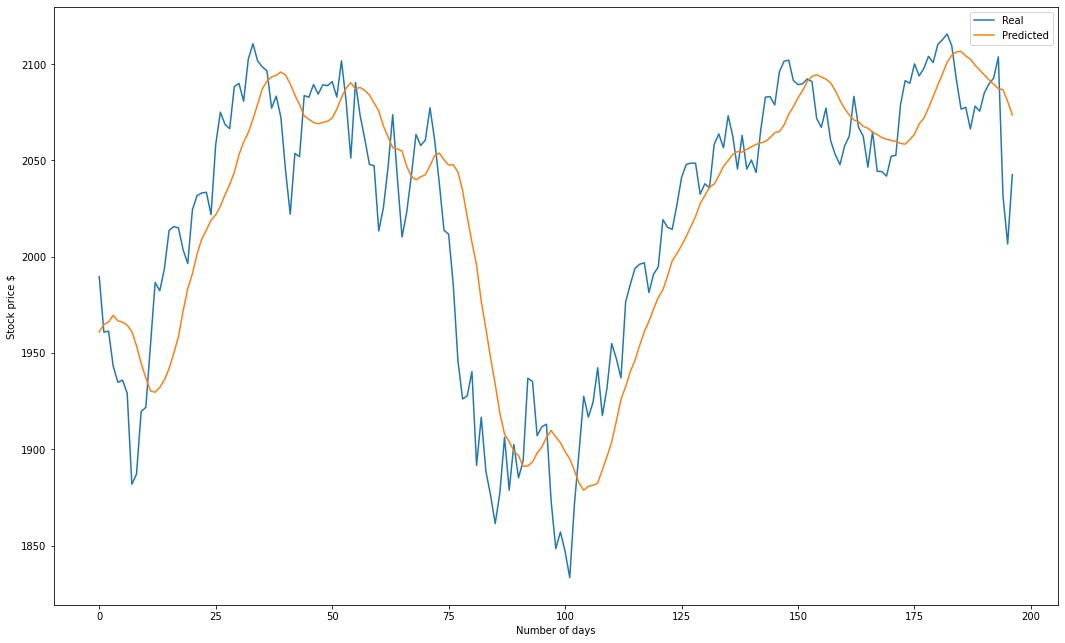

RMSE using 25 days prior: 52.02871495593043


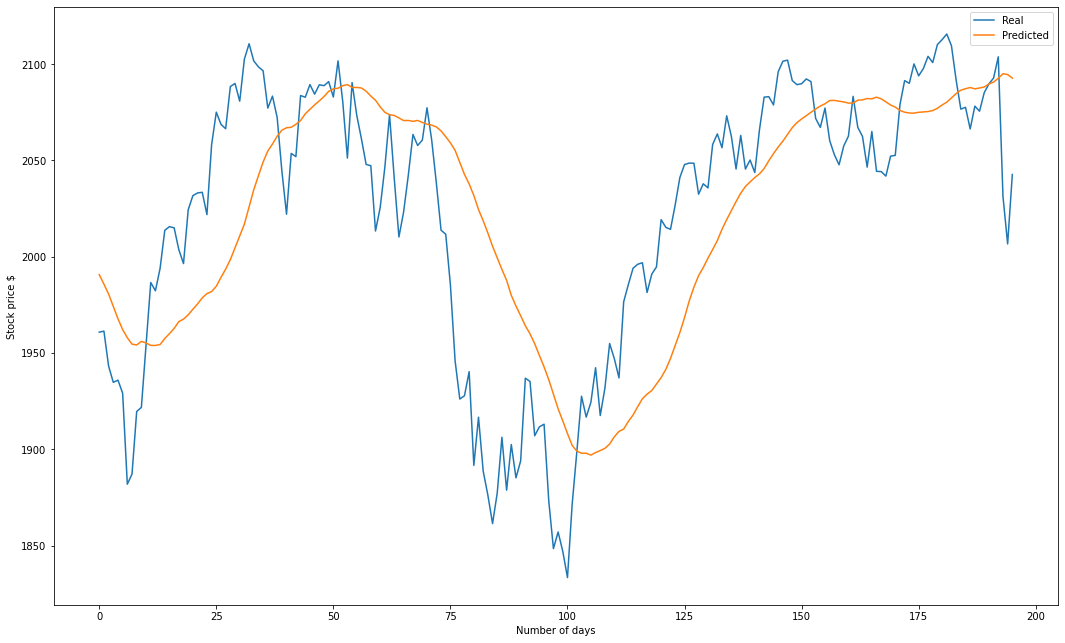

RMSE using 50 days prior: 75.64209704887038


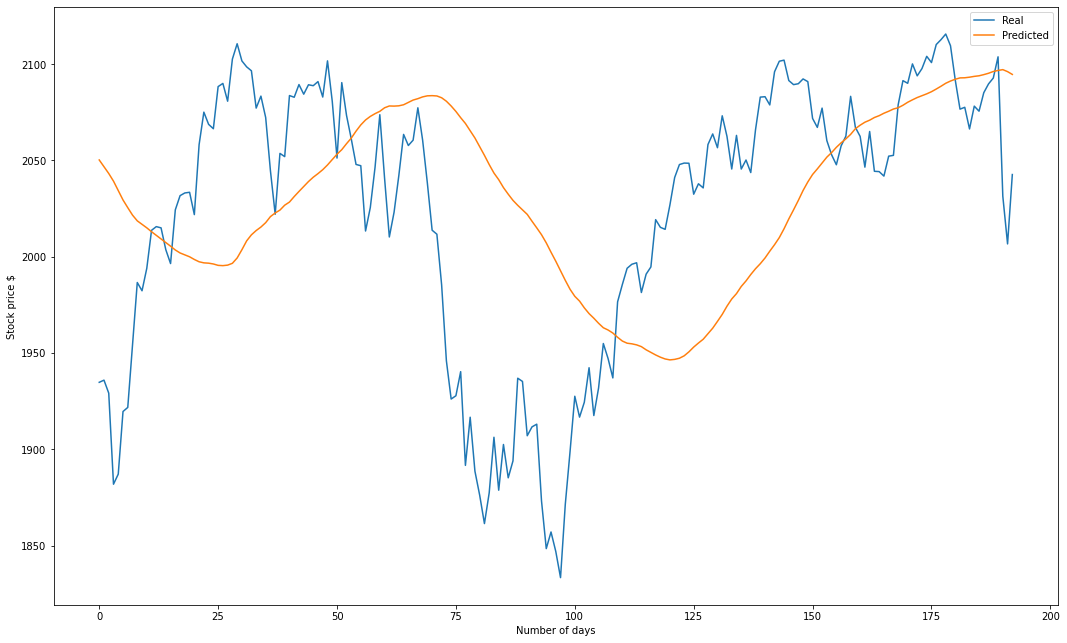

RMSE using 100 days prior: 74.74932293243174


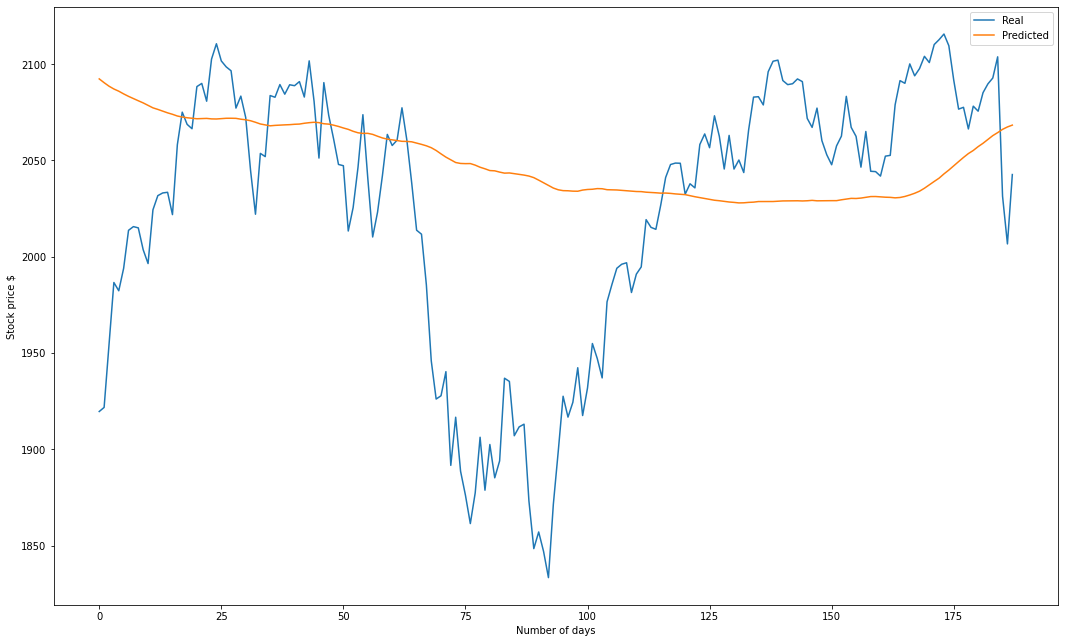

RMSE using 199 days prior: 108.97943448714146


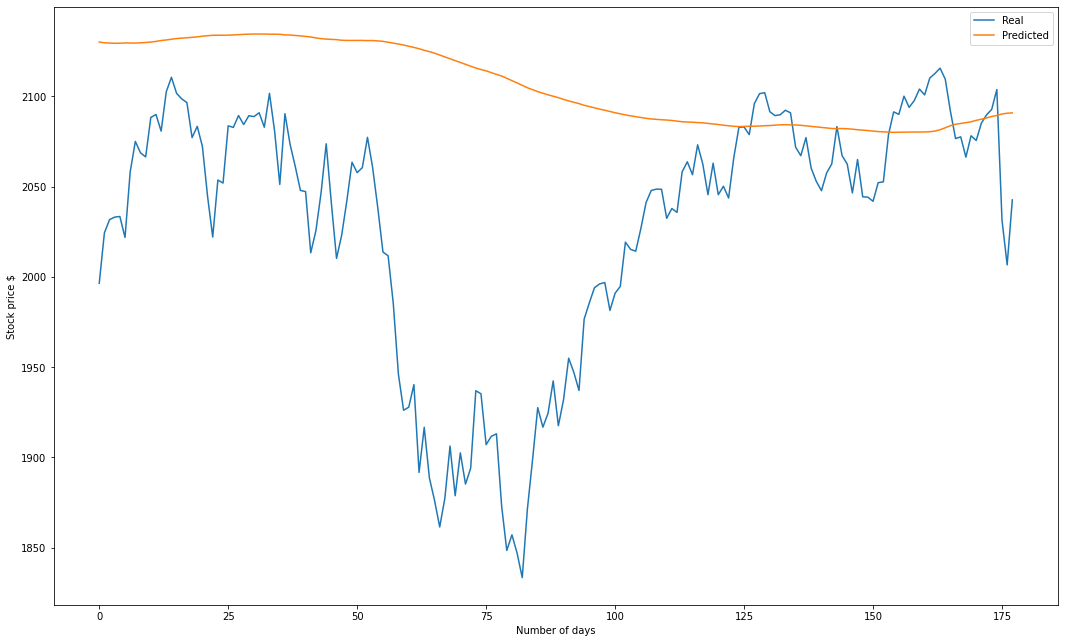

In [ ]:
rmse_values = []
for i in number_days:
  history = i
  open_prices = np.array([temp_data[i:i + history].copy() for i in range(len(temp_data) - history)])
  next_day_open_prices = np.array([temp_data[:][i + history].copy() for i in range(len(temp_data) - history)])
  average_open_prices = open_prices.mean(axis=1)
  average_open_prices = average_open_prices.reshape(-1, 1)

  test_split = 0.9
  n = int(average_open_prices.shape[0] * test_split)
  average_open_prices_train = average_open_prices[:n]
  y_train = next_day_open_prices[:n]

  average_open_prices_test = average_open_prices[n:]
  y_test = next_day_open_prices[n:]

  reg = LinearRegression()
  reg.fit(average_open_prices_train, y_train)
  predicted = reg.predict(average_open_prices_test)

  rmse =  np.sqrt(np.mean(np.square(y_test - predicted)))
  rmse_values.append(rmse)
  print(f"RMSE using {i} days prior: {rmse}")
  plt.gcf().set_size_inches(18, 11, forward=True)
  real = plt.plot(y_test[0:-1], label='real')
  pred = plt.plot(predicted[0:-1], label='predicted')

  plt.xlabel('Number of days')
  plt.ylabel('Stock price $')

  plt.legend(['Real', 'Predicted', 'Average'])
  plt.show();

## The LSTM Model


This model will take two inputs, the *ohlcv_histories* and the *technical_indicator* to output a price. *technical_indicator* contains the SMA of the data in that given period (in the LSTM model, it will be 10 since thats what history_points is)

In [ ]:
np.random.seed(2)
tf.random.set_seed(2)

# dataset
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser, history_points = get_dataset(data, 10)

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)

(1780, 10, 5)
(198, 10, 5)


In [ ]:
# model architecture

# will take two sets of inputs
lstm_input = keras.layers.Input(shape=(history_points, 5), name='lstm_input')
dense_input = keras.layers.Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = keras.layers.LSTM(50, name='lstm_0')(lstm_input)
x = keras.layers.Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = keras.models.Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = keras.layers.Dense(20, name='tech_dense_0')(dense_input)
y = keras.layers.Activation("relu", name='tech_relu_0')(y)
y = keras.layers.Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = keras.models.Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = keras.layers.concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = keras.layers.Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = keras.layers.Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = keras.models.Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = keras.optimizers.Adam(lr=0.0005)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tech_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
lstm_input (InputLayer)         [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
tech_dense_0 (Dense)            (None, 20)           40          tech_input[0][0]                 
__________________________________________________________________________________________________
lstm_0 (LSTM)                   (None, 50)           11200       lstm_input[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)

Epoch 1/50
51/51 [==============================] - 8s 15ms/step - loss: 0.1973 - val_loss: 0.2089
Epoch 2/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0366 - val_loss: 0.0027
Epoch 3/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 4/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 5/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 6/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 7.2611e-04
Epoch 8/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 9/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/50
51

Using values 10 days prior to predict next day value, the LSTM model has slightly better RMSE than the Linear Regression model that also uses 10 days of prices prior to prediction.

In [ ]:
# evaluation
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape

rmse = np.sqrt(np.mean(np.square(unscaled_y_test - y_test_predicted)))
print(f"RMSE: {rmse}")

RMSE: 31.82637203556349


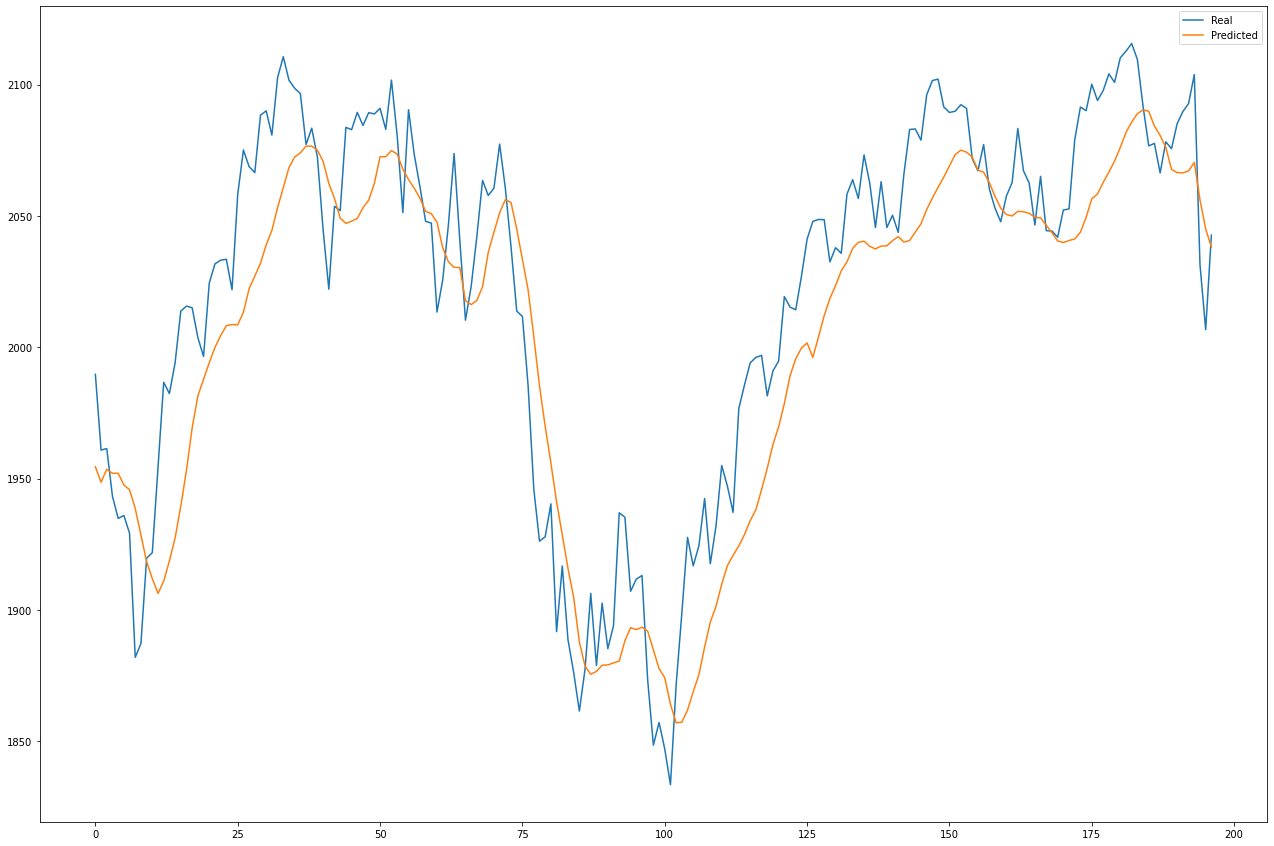

In [ ]:
start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.gcf().set_size_inches(22, 15, forward=True)
plt.legend(['Real', 'Predicted'])
plt.show()

## Investment Strategy

Here depending on the price change and the predictions of the model, it will indicate when to buy and when to sell. *price_today* goes through all the values of the test set, and tells us the price of that day. *predicted_price_tomorrow* is the price the model thinks that it will be the next day, and *delta* is the differences between those. If *delta* is above our threshold, the *buy* list will add the day and the price. Same thing with *sells* list.

In [ ]:
buy, sell, threshold = [], [], 0.1
x = -1
for ohlcv, indicator in zip(ohlcv_test[start:end], tech_ind_test[start:end]):
  normalised_price_today = ohlcv[-1][0]
  normalised_price_today = np.array([[normalised_price_today]])
  price_today = y_normaliser.inverse_transform(normalised_price_today)
  predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([np.array([ohlcv]), np.array([indicator])])))
  delta = predicted_price_tomorrow - price_today
  if delta > threshold:
    buy.append((x, price_today[0][0]))
  elif delta < -threshold:
    sell.append((x, price_today[0][0]))
  x += 1

It seems that the bot has lost $-110.67 over a span of about 200 days based on the model's predictions. 



In [ ]:
# a function to see how much the bot made
def compute_earnings(buys, sells):
  stock, balance = 0, 0
  while len(buys) > 0 and len(sells) > 0:
    if buys[0][0] < sells[0][0]:
      # buy a stock at that price
      balance -= buys[0][1]
      stock += 1
      buys.pop(0)
    else:
      # sell all
      balance += stock * sells[0][1]
      stock = 0
      sells.pop(0)
  print(f"P/L: ${balance}")
 
compute_earnings([b for b in buy], [s for s in sell])

P/L: $-110.67016601562864


Here we can see the indicators the model predicted where to buy and where to sell.

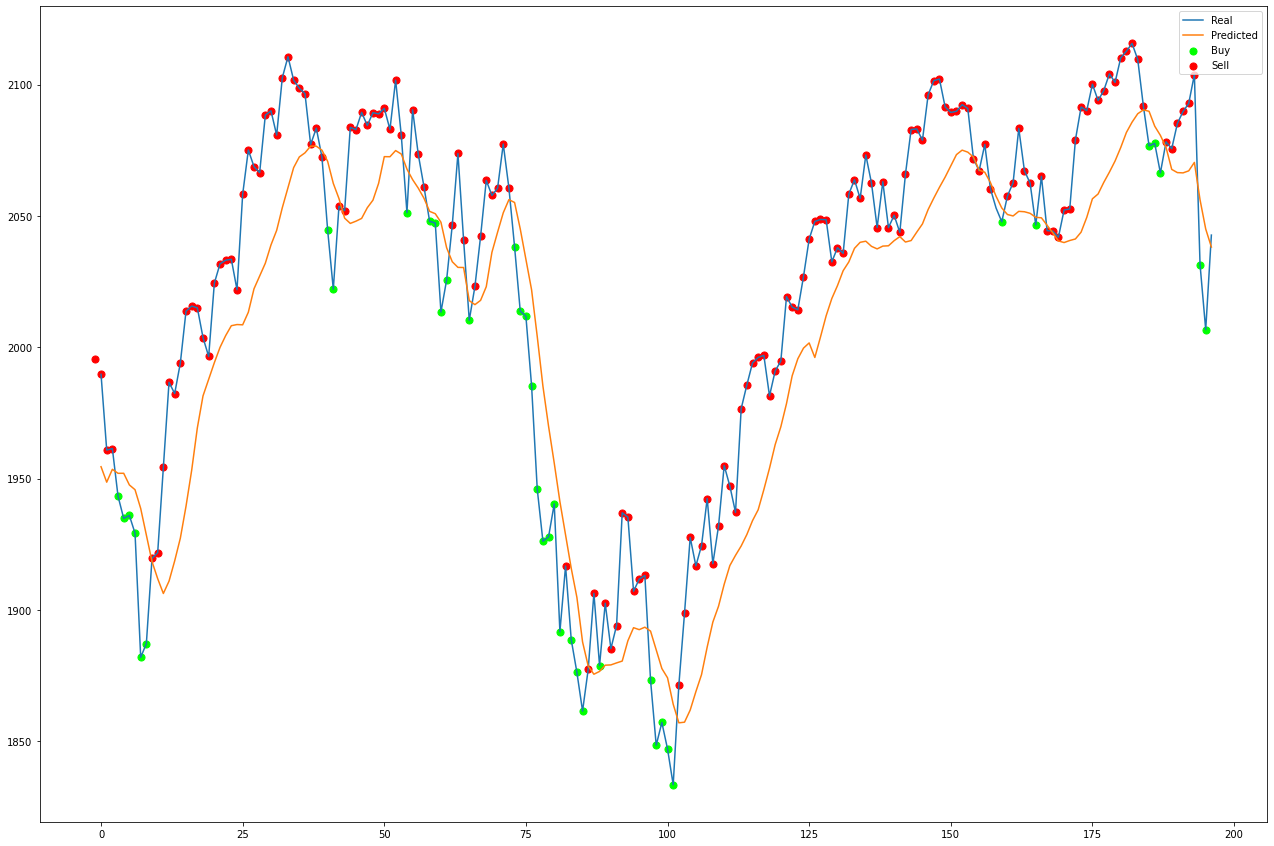

In [ ]:
plt.gcf().set_size_inches(22, 15, forward=True)

real = plt.plot(unscaled_y_test[start:end], label='real')
predicted = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buy) > 0:
  plt.scatter(list(list(zip(*buy))[0]), list(list(zip(*buy))[1]), c='#00ff00', s=50)
if len(sell) > 0:
  plt.scatter(list(list(zip(*sell))[0]), list(list(zip(*sell))[1]), c="#ff0000", s=50)

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])
plt.show()

# Model that grid searches & uses news data
https://medium.com/@Currie32/predicting-the-stock-market-with-the-news-and-deep-learning-7fc8f5f639bc

This code uses reddit headline news data to make predictions. This constrains the testing to a smaller set of dates than what the other models we were using.
Both models are using S&P500 data from yahoo finance. Preprocessing, grid search, and the way that the NN makes predictions are based on the above reference blog post.

### Start by getting some of the data that is required for the project

I'll be getting stock data twice. Once as predictors, and once for target. The target set will use 3-days before.


In [ ]:
raw_Daily = yf.download('^GSPC', '2018-12-31', '2020-12-15')

[*********************100%***********************]  1 of 1 completed


In [ ]:
start_date = '2008-08-08'
end_date = '2016-07-01'
Multi_Model_Test_Data = yf.download('^GSPC', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
Daily = raw_Daily[["Close"]]
multi_Daily = Multi_Model_Test_Data[["Close"]]
Daily.describe()

,Close
count,494.000000
mean,3049.062242
std,278.469261
min,2237.399902
25%,2867.539978
50%,3000.419922
75%,3256.237549
max,3702.250000


Here is a quick visualization of the data.

In [ ]:
Daily["returns"] = Daily.Close.pct_change()
multi_Daily["returns"] = multi_Daily.Close.pct_change()
Daily.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,returns
Date,,
2018-12-31,2506.850098,NaN
2019-01-02,2510.030029,0.001268
2019-01-03,2447.889893,-0.024757
2019-01-04,2531.939941,0.034336
2019-01-07,2549.689941,0.007010


In [ ]:
Daily["log_returns"] = np.log(1 + Daily["returns"])
multi_Daily["log_returns"] = np.log(1 + multi_Daily["returns"])
Daily.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,returns,log_returns
Date,,,
2018-12-31,2506.850098,NaN,NaN
2019-01-02,2510.030029,0.001268,0.001268
2019-01-03,2447.889893,-0.024757,-0.025068
2019-01-04,2531.939941,0.034336,0.033759
2019-01-07,2549.689941,0.007010,0.006986


Log resturns is one of the suggested methods for making predictions, because it normalizes the data, and sets the mean to zero, so that the neural net can focus on if there will be upward, or downward changes in price, instead of finding other features in the data such as slope. (Though knowing the slope would be useful for long term trends)

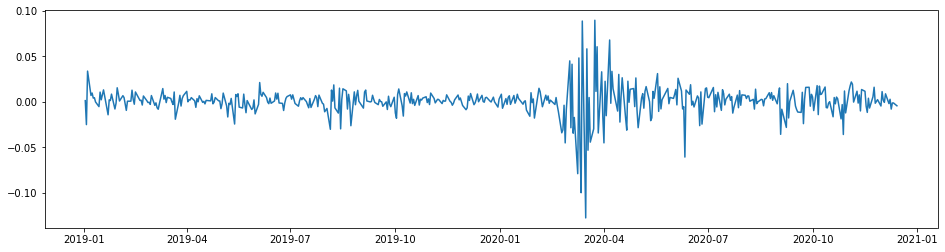

In [ ]:
plt.figure(1, figsize=(16, 4))
plt.plot(Daily.log_returns)

Here below is a series of preprocessing steps. The data is being preprocessed this way so that it matches up with the proper format of input later on.

In [ ]:
Daily.dropna(inplace=True)
multi_Daily.dropna(inplace=True)
X = Daily[["Close", "log_returns"]].values
multi_X = multi_Daily[["Close", "log_returns"]].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
multi_scaler = MinMaxScaler(feature_range=(0,1)).fit(multi_X)
X_scaled = scaler.transform(X)
multi_X_scaled = multi_scaler.transform(multi_X)
X_scaled[:5]

array([[0.18611469, 0.59318396],
       [0.14369388, 0.4720071 ],
       [0.2010718 , 0.74268423],
       [0.21318908, 0.61949482],
       [0.2300645 , 0.63174598]])

In [ ]:
y = [x[0] for x in X_scaled]
multi_y = [x[0] for x in multi_X_scaled]

In [ ]:
split = int(len(X_scaled) * 0.8)
print(split)

394


In [ ]:
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]
y_test = y[split : len(y)]


In [ ]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

### Three days given to predict price
This code here is creating price arrays with price information for the prior three days. In order to concatenate it to the models, the input was padded by taking three days adding a little randomness and using that as padding.

In [ ]:
n = 3
Xtrain = []
ytrain = []
Xtest = []
ytest = []

y_multi = []
X_multi = []

for i in range(n,len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i]) # predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i]) #predict next record
    
#This bit of seeming non-sense is because the variable needs padding in order to have the proper
#Size for the later neural network. To do this i'm repeating the first three values and altering them slightly with noise
for i in range(0,n):
    zrx =random.random()
    zry =random.random()
    if random.random() < 0.5:
        zrx = zrx * (-1)
    if random.random() < 0.5:
        zry = zry * (-1)
    X_multi.append(multi_X[i : i+n, : multi_X.shape[1]]+[zrx,zry])
    y_multi.append(multi_y[i])
    print(X_multi)        
    
for i in range(n, len(multi_X)):
    X_multi.append(multi_X[i -n : i, : multi_X.shape[1]])
    y_multi.append(multi_y[i])



[array([[1.30512633e+03, 7.83448579e-01],
       [1.28939635e+03, 7.64405970e-01],
       [1.28563634e+03, 7.73609917e-01]])]
[array([[1.30512633e+03, 7.83448579e-01],
       [1.28939635e+03, 7.64405970e-01],
       [1.28563634e+03, 7.73609917e-01]]), array([[1.28998464e+03, 1.45362230e-01],
       [1.28622463e+03, 1.54566176e-01],
       [1.29332473e+03, 1.62992710e-01]])]
[array([[1.30512633e+03, 7.83448579e-01],
       [1.28939635e+03, 7.64405970e-01],
       [1.28563634e+03, 7.73609917e-01]]), array([[1.28998464e+03, 1.45362230e-01],
       [1.28622463e+03, 1.54566176e-01],
       [1.29332473e+03, 1.62992710e-01]]), array([[1.28516897e+03, 8.79560752e-01],
       [1.29226906e+03, 8.87987286e-01],
       [1.29753896e+03, 8.86548323e-01]])]


In [ ]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

X_multi, y_multi = (np.array(X_multi), np.array(y_multi))
X_multi = np.reshape(X_multi, (X_multi.shape[0], X_multi.shape[1], X_multi.shape[2]))

The model requires the use of news data,and GloVe's embedding. Mounting google drive for read/write usage.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/Shareddrives/Machine Learning/"

 BrunsSketch.PNG      'Machine Learning Project Definition.gdoc'   Pre-prep
 glove.840B.300d.txt   News.csv					   SNP500.csv


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Getting stock data to match the model above.

In [ ]:
# get the data
start_date = '2008-08-08'
end_date = '2016-07-01'
S_NP500 = yf.download('^GSPC', start_date, end_date)
S_NP500 = S_NP500.drop('Adj Close', axis=1)
S_NP500['Date'] = S_NP500.index
data = S_NP500.values
print(S_NP500)


[*********************100%***********************]  1 of 1 completed
                   Open         High  ...      Volume       Date
Date                                  ...                       
2008-08-08  1266.290039  1297.849976  ...  4966810000 2008-08-08
2008-08-11  1294.420044  1313.150024  ...  5067310000 2008-08-11
2008-08-12  1304.790039  1304.790039  ...  4711290000 2008-08-12
2008-08-13  1288.640015  1294.030029  ...  4787600000 2008-08-13
2008-08-14  1282.109985  1300.109985  ...  4064000000 2008-08-14
...                 ...          ...  ...         ...        ...
2016-06-24  2103.810059  2103.810059  ...  7597450000 2016-06-24
2016-06-27  2031.449951  2031.449951  ...  5431220000 2016-06-27
2016-06-28  2006.670044  2036.089966  ...  4385810000 2016-06-28
2016-06-29  2042.689941  2073.129883  ...  4241740000 2016-06-29
2016-06-30  2073.169922  2098.939941  ...  4622820000 2016-06-30

[1988 rows x 6 columns]


In [ ]:
S_NP500.to_csv("SNP500.csv", encoding='utf-8', index=False)

In [ ]:
news = pd.read_csv("/content/gdrive/Shareddrives/Machine Learning/News.csv")

In [ ]:
S_NP500 = pd.read_csv("/content/gdrive/Shareddrives/Machine Learning/SNP500.csv")
S_NP500.head()

,Open,High,Low,Close,Volume,Date
0,1266.290039,1297.849976,1262.109985,1296.319946,4966810000,2008-08-08
1,1294.420044,1313.150024,1291.410034,1305.319946,5067310000,2008-08-11
2,1304.790039,1304.790039,1285.640015,1289.589966,4711290000,2008-08-12
3,1288.640015,1294.030029,1274.859985,1285.829956,4787600000,2008-08-13
4,1282.109985,1300.109985,1276.839966,1292.930054,4064000000,2008-08-14


Preprocessing so dates line up and data types are compatible. With many steps to check this inbetween.

In [ ]:
S_NP500.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Date      0
dtype: int64

In [ ]:
news.isnull().sum()

Date    0
News    0
dtype: int64

In [ ]:
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [ ]:
print(S_NP500.shape)
print(news.shape)

(1988, 6)
(73608, 2)


In [ ]:
# Compare the number of unique dates. We want matching values.
print(len(set(S_NP500.Date)))
print(len(set(news.Date)))

1988
2943


In [ ]:
# Remove the extra dates that are in news
news = news[news.Date.isin(S_NP500.Date)]

In [ ]:
print(len(set(S_NP500.Date)))
print(len(set(news.Date)))

1988
1988


In [ ]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict how much the Open value will change beased on the news.
S_NP500 = S_NP500.set_index('Date').diff(periods=1)
S_NP500['Date'] = S_NP500.index
S_NP500 = S_NP500.reset_index(drop=True)

In [ ]:
# Remove unneeded features
S_NP500 = S_NP500.drop(['High','Low','Close','Volume'], 1)

In [ ]:
S_NP500.head()

,Open,Date
0,NaN,2008-08-08
1,28.130005,2008-08-11
2,10.369995,2008-08-12
3,-16.150024,2008-08-13
4,-6.530029,2008-08-14


In [ ]:
# Remove top row since it has a null value.
S_NP500 = S_NP500[S_NP500.Open.notnull()]
# Check if there are any more null values.
S_NP500.isnull().sum()

Open    0
Date    0
dtype: int64

We need to make sure that the prices and news data have the same data ranges.


In [ ]:
# Create a list of the opening prices and their corresponding daily headlines
# from the news
price = []
headlines = []

for row in S_NP500.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Open'])
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])
    
    # Track progress
    headlines.append(daily_headlines)
    if (len(price) % 500 ==0):
        print(len(price))

500
1000
1500


In [ ]:
# Compare lengths to ensure they are the same
print(len(price))
print(len(headlines))

1987
1987


In [ ]:
# Compare the number of headlines for each day
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))
#print(np.mean(len(i) for i in headlines))

25
22


This is where some of the news headlines begins to be transformed so that it is more readily interpreted and used by the neural net. (also helps prevent errors). Some contractions are removed, and some words and word patterns are altered. We will then check for any embeddings that might not be within GloVe.

In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    # Format words and remove unwanted characters
    
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    return text

In [ ]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [ ]:
#Take a look at some headlines to ensure everything was cleaned well
clean_headlines[0]

['b wont america nato help us wont help us help iraq',
 'b bush puts foot georgian conflict',
 'b jewish georgian minister thanks israeli training fending russia',
 'b georgian army flees disarray russians advance gori abandoned russia without shot fired',
 'b olympic opening ceremony fireworks faked',
 'b mossad fraudulent new zealand passports iraq',
 'b russia angered israeli military sale georgia',
 'b american citizen living ossetia blames united states georgian leaders genocide innocent people',
 'b welcome world war iv high definition',
 'b georgia move mistake monumental proportions',
 'b russia presses deeper georgia united states says regime change goal',
 'b abhinav bindra wins first ever individual olympic gold medal india',
 'b united states ship heads arctic define territory',
 'b drivers jerusalem taxi station threaten quit rather work new boss arab',
 'b french team stunned phelps 4x100m relay team',
 'b israel us behind georgian aggression',
 'b believe tv neither russ

In [ ]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
                
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 35186


### Using GloVe's word embeddings

In [ ]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/content/gdrive/Shareddrives/Machine Learning/glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
        
print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196016


In [ ]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100

print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 47
Percent of words that are missing from vocabulary: 0.13%


In [ ]:
# Limit the vocab that we will use to words that appear > threashold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {}

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1
        
# Special tokens that will be added to our vocab
codes = ["<UNK>", "<PAD>"]

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)
    
# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word
    
usage_ratio = round(len(vocab_to_int)/len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))



Total Number of Unique Words: 35186
Number of words we will use: 31263
Percent of Words we will use: 88.85%


In [ ]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding
        
# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

31263


In [ ]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK>
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)
    
unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 615713
Total number of UNKs in headlines: 5260
Percent of words that are UNK: 0.8500000000000001%


In [ ]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))
        
# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [ ]:
lengths.describe()

,counts
count,49668.000000
mean,12.396573
std,6.791155
min,1.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,41.000000


In [ ]:
# Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and
# Balance the number of healines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

#### Normalizing the Price Data
This is similar to what was done in the prior models.

In [ ]:
print(max(price))

97.219970703125


In [ ]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
#mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [ ]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [ ]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.4970965262913097


### Creating Training Test data

In [ ]:
# Split data into training and testing sets.
# Validating data will be created during training.
#x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train, x_test, y_train, y_test, X_multi_tr, X_multi_te = train_test_split(pad_headlines, norm_price, X_multi, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_multi_split = np.array(X_multi_tr)
X_multi_te = np.array(X_multi_te)


In [ ]:
print(X_multi_split.shape)
print(X_multi_tr.shape)
print(X_multi_te.shape)

(1688, 3, 2)
(1688, 3, 2)
(299, 3, 2)


In [ ]:
# Check the lengths
print(len(x_train))
print(len(x_test))
print(x_train.shape)
print(word_embedding_matrix.shape)
print(nb_words)
print(embedding_dim)
#print(weights)

1688
299
(1688, 200)
(31263, 300)
31263
300


In [ ]:
nsamples, nx, ny = X_multi_split.shape
X_multi_split = X_multi_split.reshape((nsamples,nx*ny))
print(X_multi_split.shape)

(1688, 6)


In [ ]:
data_normaliser = preprocessing.MinMaxScaler()
X_multi_split = data_normaliser.fit_transform(X_multi_split)
print(X_multi_split.shape)

(1688, 6)


In [ ]:
nsamples, nx, ny = X_multi_te.shape
X_multi_te = X_multi_te.reshape((nsamples,nx*ny))
print(X_multi_te.shape)

data_normaliser = preprocessing.MinMaxScaler()
X_multi_te = data_normaliser.fit_transform(X_multi_te)
print(X_multi_te.shape)

(299, 6)
(299, 6)


### Creating the Model
The model uses grid search to optimize. It consists of three braches, two of which train on the news data, and then they are concatenated with the price data and fed through some additional layers. The model uses early stopping, and alters the learning rate when it detects a plateau.

In [ ]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True

if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2

#Will need to accept a shape for input, and input?
## model1_inputs = keras.Input(shape=(784,))
def build_model():
    model1_input = keras.Input(shape=[x_train.shape[1]], name="model1_input")
    model2_input = keras.Input(shape=[x_train.shape[1]], name="model2_input")
    n_day_price_input = keras.Input(shape=[X_multi_split.shape[1]], name="n_day_prices")
    
    #embed_input = keras.Input(shape=[nb_words,embedding_dim])
    
    x = layers.Embedding(nb_words,
                         embedding_dim,
                         weights=[word_embedding_matrix],
                         input_length=max_daily_length)(model1_input)

    x = keras.layers.Dropout(dropout)(x)
    
    x = keras.layers.Conv1D(filters = nb_filter,
                           kernel_size = filter_length1,
                           padding = 'same',
                           activation = 'relu')(x)
    
    x = keras.layers.Dropout(dropout)(x)

    
    if deeper == True:
        x = keras.layers.Conv1D(filters = nb_filter,
                              kernel_size = filter_length1,
                              padding = 'same',
                              activation = 'relu')(x)

        x = keras.layers.Dropout(dropout)(x)
        
    model1_output = keras.layers.LSTM(rnn_output_size,
                               activation=None,
                               kernel_initializer=weights,
                               dropout = dropout)(x)
    
    model1 = keras.Model(model1_input, model1_output, name='model1')
    model1.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    #####
    
    x2 = word_embedding = layers.Embedding(nb_words,
                                                   embedding_dim,
                                                   weights=[word_embedding_matrix],
                                                   input_length=max_daily_length)(model2_input)
    
    x2 = keras.layers.Dropout(dropout)(x2)
    
    x2 = keras.layers.Conv1D(filters = nb_filter,
                           kernel_size = filter_length2,
                           padding = 'same',
                           activation = 'relu')(x2)
                           
    x2 = keras.layers.Dropout(dropout)(x2)
    
    if deeper == True:
        x2  = keras.layers.Conv1D(filters = nb_filter,
                                 kernel_size = filter_length2,
                                 padding = 'same',
                                 activation = 'relu')(x2)
                                 
        x2 = keras.layers.Dropout(dropout)(x2)
        
    model2_output = keras.layers.LSTM(rnn_output_size,
                          activation = None,
                          kernel_initializer=weights,
                          dropout = dropout)(x2)
    
    model2 = keras.Model(model2_input, model2_output, name='model2')
    model2.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))

    #####
    final_model_concatenated = Concatenate(name='concat_1')([model1_output, model2_output, n_day_price_input])
    
    final_model_concatenated = keras.layers.Dense(hidden_dims, kernel_initializer=weights)(final_model_concatenated)

    final_model_concatenated = keras.layers.Dropout(dropout)(final_model_concatenated)
    
    if deeper == True:
        final_model_concatenated = keras.layers.Dense(hidden_dims//2, kernel_initializer=weights)(final_model_concatenated)

        final_model_concatenated = keras.layers.Dropout(dropout)(final_model_concatenated)


    final_model_output = keras.layers.Dense(1,kernel_initializer = weights, name='output')(final_model_concatenated)
    
    final_model = keras.Model(inputs=[model1_input, model2_input, n_day_price_input], outputs=final_model_output)
    
    final_model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    
    ##define model1 output
    #fianl_model = keras.Model(model2_input, model2_output, name='model2')
    #model2.compile(loss='mean_squared_error',
    #              optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    return final_model

In [ ]:
model = build_model()

In [ ]:
print(x_train.shape)
print(y_train.shape)

(1688, 200)
(1688,)


### Grid Search

In [ ]:
# Use grid search to help find a better model
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                history = model.fit([x_train,x_train,X_multi_split,],y_train,batch_size=128,epochs=100,validation_split=0.15,verbose=True, shuffle=True,callbacks = callbacks)




Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3

Epoch 1/100
12/12 [==============================] - 13s 912ms/step - loss: 1.3479 - val_loss: 0.0480
Epoch 2/100
12/12 [==============================] - 11s 887ms/step - loss: 0.1346 - val_loss: 0.0799
Epoch 3/100
12/12 [==============================] - 10s 864ms/step - loss: 0.0508 - val_loss: 0.0135
Epoch 4/100
12/12 [==============================] - 11s 895ms/step - loss: 0.0352 - val_loss: 0.0261
Epoch 5/100
12/12 [==============================] - 11s 928ms/step - loss: 0.0294 - val_loss: 0.0156
Epoch 6/100
12/12 [==============================] - 10s 863ms/step - loss: 0.0280 - val_loss: 0.0157

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/100
12/12 [==============================] - 10s 848ms/step - loss: 0.0223 - val_loss: 0.0146
Epoch 8/100
12/12 [==============================] - 10s 845ms/step - loss: 0.0255 - val_loss: 0.0137
Epoch 00008: early stopping

Current 

### Final build of the trained model

In [ ]:
# Make predictions with the best weights
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
# Need to rebuild the model, to guarantee that the best values are the most recently used ones.
model = build_model()

model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))

predictions = model.predict([x_test,x_test,X_multi_te], verbose = True)

10/10 [==============================] - 1s 75ms/step


Keras has a cool API that takes care of showing the final model's construction.

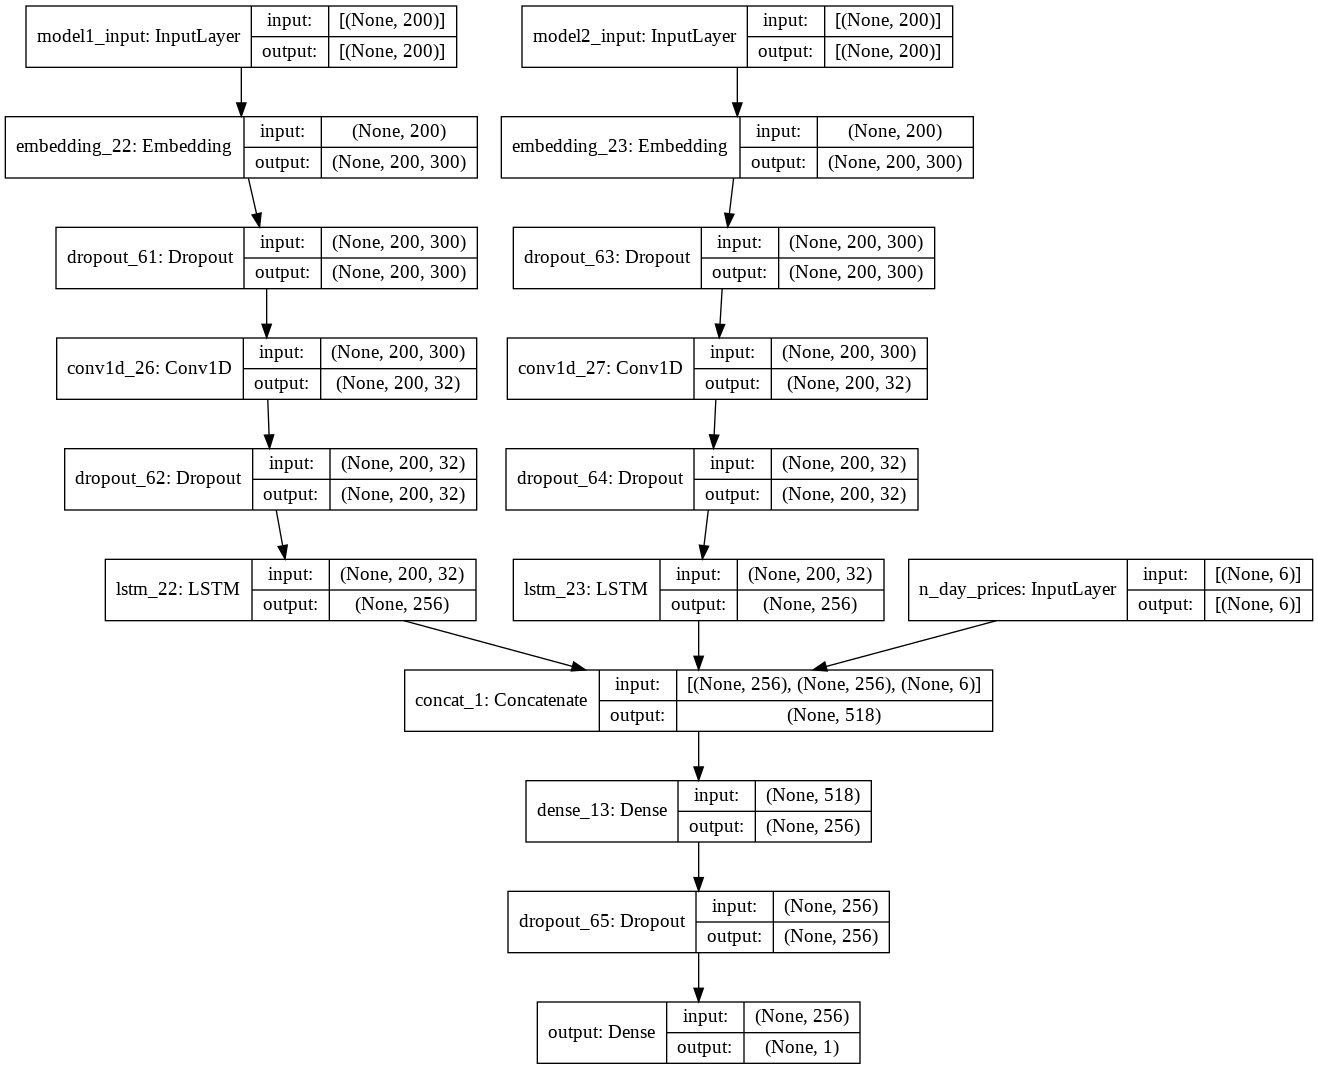

In [ ]:
keras.utils.plot_model(model, "model flowchart.png", show_shapes=True)

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model1_input (InputLayer)       [(None, 200)]        0                                            
__________________________________________________________________________________________________
model2_input (InputLayer)       [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 200, 300)     9378900     model1_input[0][0]               
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 200, 300)     9378900     model2_input[0][0]               
___________________________________________________________________________________________

### Checking How well it did
Time to take a look at how well the model does


In [ ]:
mse(y_test, predictions)

0.012993820515748529

In [ ]:
def unnormalize(price):
    '''used to walk back to the un-normalized values'''
    price = price *(max_price-min_price)+min_price
    return(price)

In [ ]:
unnorm_predictions =[]
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [ ]:
# Calculate the median absolute edrror for the predictions
mae(unnorm_y_test, unnorm_predictions)

15.244438171386719

In [ ]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  299.000000
mean     0.491236
std     16.491637
min    -52.589966
25%     -7.045044
50%      0.400024
75%      8.254944
max     97.219971

Summary of predicted opening price changes
                 
count  299.000000
mean    -3.959581
std     15.138677
min    -38.636387
25%    -14.727562
50%     -4.835335
75%      5.853027
max     49.995270


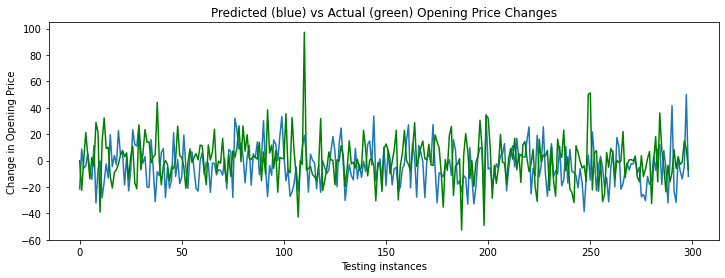

In [ ]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test, 'g')
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [ ]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

Mean of direction of data. This may have an impact on the investing strategy if it is generally higher or lower.

In [ ]:
d1 = np.array(direction_test)
d2 = pd.DataFrame(d1)
d2.mean()

0    0.518395
dtype: float64

In [ ]:
sample = []
for i in range(10000):
  sample.append(simple_invest())

sample2= np.array(sample)
sample3=pd.DataFrame(sample2)
sample3.dropna(inplace=True)


In [ ]:
sample = []
for i in range(10000):
  sample.append(simple_invest())

sample2= np.array(sample)
sample3=pd.DataFrame(sample2)
sample3.dropna(inplace=True)


In [ ]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [ ]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [ ]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 52.17% of the time.


#### A Very Simple Investing Strategy.
If price is predicted to increase, buy
If price is predicted to decrease, sell all.


In [ ]:
stock_count = 0
costs = 0
earnings = 0
stock, balance = 0, 0
for index, pred in enumerate(direction_pred):
    if pred >=0:
        #Buy
        stock_count = stock_count + 1
        costs = costs + unnorm_y_test[index]
    elif pred <= 0:
        #Sell all
        if stock_count > 0:
            earnings = stock_count * unnorm_y_test[index+1]
            stock_count = 0
            
result = earnings - costs
print("$" + str(result))

$-146.87969970703142


This model seems to have lost a little bit more money than the prior model. The end result might be improved if the news model is merged with the more advanced LSTM model. A more advanced investing strategy would also be a good idea. (Maybe future work could be done by building a neural net that makes decisions to buy or sell)


### Investing based on chance

In [ ]:
def simple_invest():
  stock_count = 0
  costs = 0
  earnings = 0
  stock, balance = 0, 0
  for index, pred in enumerate(direction_pred):
    try:  
      if random.random() > 0.5:
          #Buy
          stock_count = stock_count + 1
          costs = costs + unnorm_y_test[index]
      elif random.random() <= 0.5:
          #Sell all
          if stock_count > 0:
              earnings = stock_count * unnorm_y_test[index+1]
              stock_count = 0
    except Exception as e:
        print('oops! index out of range probably')
        return None

  result = earnings - costs
  #print("$" + str(result))
  return result

In [ ]:
sample = []
for i in range(10000):
  sample.append(simple_invest())

sample2= np.array(sample)
sample3=pd.DataFrame(sample2)
sample3.dropna(inplace=True)


In [ ]:
sample3.mean()

0   -66.916273
dtype: float64

The results of these models with a basic investing strategy are worse than chance...


# APPENDIX


# Get live news data
This section is a start showing how to get a limited amount of current news headlines from reddit/r/news, which could then be used to make predictions.

The limitation to this method is that there are api limitations to downloading a max of 1000 headlines at a time, and no feature to extract headlines by date.

It would be useful for daily predictions though. It's included as a start for future investigation, not intended to be used.


In [ ]:
#This will require registering with Reddit.
#You can register for api access by visiting https://www.reddit.com/prefs/apps.
#There will be a button towards the bottom about developers and developing apps.
#Click that. Fill in the form, and then use the resulting values to fill in the
#parameters below.
import praw

reddit = praw.Reddit(client_id='',
                     client_secret='',
                     user_agent='')

In [ ]:
headlines = set()
for submission in reddit.subreddit('news').new(limit=None):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))